# 02: Parameters, Patches and the Synth

Great. So now we can create Surge and play it in python, as shown in example 01. But surge is a synth
with a large number of parameters and a very flexibly modulation architecture. How do we manipulate that
in python? There's a variety of APIs Surge exposes to that end, but by far the most common one you will
need is to interact with the patch architecture.

So lets start with a relatively standard prologue to install and setup surge.

In [1]:
import sys
# Replace this with a path to the built surgepy 
sys.path.append( "../../surge/cmake-build-debug-xc" )

import os
import surgepy
import surgepy.constants as srco
import numpy as np
import IPython

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

surgepy.getVersion()

'1.8.more-python.185c1075'

## Loading Factory Patches

Surge comes with a large number of factory patches. The easiest way to configure surge is to load one. Lets see
how to do that by making a function which plays a C-maj7 chord for a second with release and playing it on a couple 
of patches. A correctly installed surge allows you to find the location of the factory patches through an API 
then call load.

In [2]:
def c7ChordOnPatch( patchN ):
    s = surgepy.createSurge( 44100 )
    fd = s.getFactoryDataPath()
    s.loadPatch( os.path.join(fd, patchN) )
    
    onesec = int( s.getSampleRate() / s.getBlockSize())
    buf = s.createMultiBlock( 2 * onesec)
    
    chd = [ 60, 63, 67, 71 ]
    for n in chd:
        s.playNote( 0, n, 127, 0 )
    s.processMultiBlock( buf, 0, onesec )
    
    for n in chd:
        s.releaseNote( 0, n, 0 )
    s.processMultiBlock( buf, onesec )
    
    return buf
    
dx = c7ChordOnPatch( "patches_factory/Keys/DX EP.fxp")
IPython.display.Audio( dx, rate=44100 )

In [3]:
br = c7ChordOnPatch( "patches_factory/Brass/Toto Brass.fxp")
IPython.display.Audio( br, rate=44100 )

## Interacting directly with the patch parameters

At this point, we will start itneracting directly with the surge parameters. If you have not used the Surge
synth, this is going to get harder to follow. We strongly recommend downloading the Surge instrument and playing
around with it in your daw a little so you know what it does.

Surge's internal data model is based on a few key concepts

* A Parameter 
    * Holds a name, type, value, default, min and max. 
    * Setting the value on a parameter is the fundamental user action to change surge.
    * It can format values to strings and so forth.
    * Parameters sometimes take values which are named constants, especiall for discrete values (like filter types).
* A Modulation Source 
    * For instance, an LFO or keyboard velocity.
    * The starting point in the modulation matrix. It is covered in a later notebook. 
    * A Parameter, Modulation Source and Depth together are a Modulation Routing.
* A Patch is a hierarchical arrangement of parmeters and a list of Modulation Routings.
* The synth also has a runtime arrangement of parameters (the 'control groups') covered later.

In this notebook we investigate only Patches and Parameters. We have modeled these interactions in python
through a patch dictionary which is a hierarchy of keys and parameters.

Lets take the simplest example. We can create a surge and look at scene 0's oscillator 0. We will see this gives 
us a structure with some named parameters (type, pitch, etc...) and also a list 'p' of the oscillator control
params which map to the sliders you see in the Oscillator section of the display in the VI.

In [4]:
s = surgepy.createSurge(44100)
patch = s.getPatch()
patch["scene"][0]["osc"][0]

{'type': <SurgeNamedParam 'A Osc 1 Type'>,
 'pitch': <SurgeNamedParam 'A Osc 1 Pitch'>,
 'octave': <SurgeNamedParam 'A Osc 1 Octave'>,
 'keytrack': <SurgeNamedParam 'A Osc 1 Keytrack'>,
 'retrigger': <SurgeNamedParam 'A Osc 1 Retrigger'>,
 'p': [<SurgeNamedParam 'A Osc 1 Shape'>,
  <SurgeNamedParam 'A Osc 1 Width 1'>,
  <SurgeNamedParam 'A Osc 1 Width 2'>,
  <SurgeNamedParam 'A Osc 1 Sub Mix'>,
  <SurgeNamedParam 'A Osc 1 Sync'>,
  <SurgeNamedParam 'A Osc 1 Unison Detune'>,
  <SurgeNamedParam 'A Osc 1 Unison Voices'>]}

We had also mentioned that surge exports a set of constants which we can use as values or indices. 
Lets use that here to grab the amplitude envelope parameters for scene 0.

In [5]:
import surgepy.constants as srco

ampeg0 = patch["scene"][0]["adsr"][srco.adsr_ampeg]
ampeg0

{'a': <SurgeNamedParam 'A Amp EG Attack'>,
 'd': <SurgeNamedParam 'A Amp EG Decay'>,
 's': <SurgeNamedParam 'A Amp EG Sustain'>,
 'r': <SurgeNamedParam 'A Amp EG Release'>,
 'a_s': <SurgeNamedParam 'A Amp EG Attack Shape'>,
 'd_s': <SurgeNamedParam 'A Amp EG Decay Shape'>,
 'r_s': <SurgeNamedParam 'A Amp EG Release Shape'>,
 'mode': <SurgeNamedParam 'A Amp EG Envelope Mode'>}

This is a map of SurgeNamedParam. A SurgeNamedParam is a holder for a parameter index which 
lets us ask questions about the parameter from the synth. That is, rather than `param.getValue` you say `synth.getParamVal(param)`. Lets check this out with the attack param. We will see that the attack param
has a range from -8 to 5 with a default of -8 which corresponds to a 0 second attack. We will then change the value
to -5 and see what the stringification is (like most time params in surge the value is stored as the log of the time)

In [6]:
atk = ampeg0["a"]
print( [
    s.getParamVal(atk),
    s.getParamMin(atk),
    s.getParamMax(atk),
    s.getParamDef(atk),
    s.getParamValType(atk),
    s.getParamDisplay(atk)
])

s.setParamVal( atk, -5);
print( s.getParamVal(atk), " -> ", s.getParamDisplay(atk))

s.setParamVal( atk, 0);
print( s.getParamVal(atk), " -> ", s.getParamDisplay(atk))



[-8.0, -8.0, 5.0, -8.0, 'float', '0.000 s']
-5.0  ->  0.031 s
0.0  ->  1.000 s


Now we know how the attack (and release) work we can make a little grid of envelope behavior. Lets
write a function which sets the decay to -4 and the sustain to 50% then modifies the attack and decay and put
it in a little grid plot.

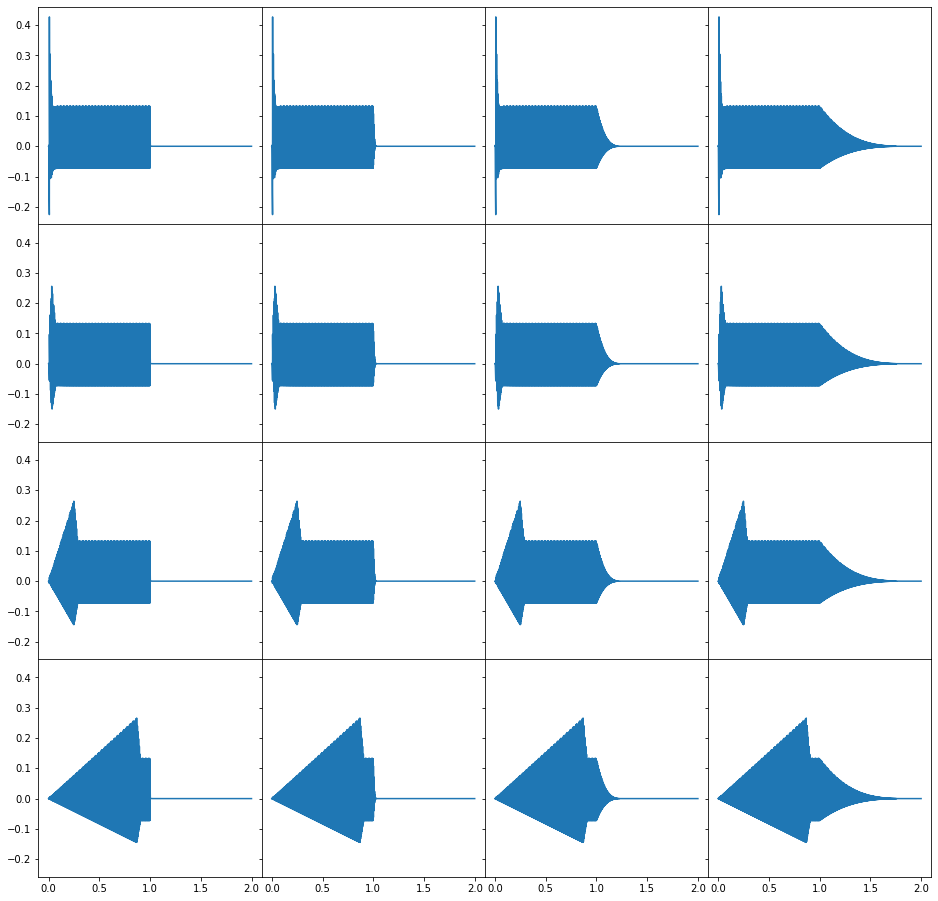

In [7]:
def playWithAR(a, r):
    surge = surgepy.createSurge(44100)
    
    onesec = int( s.getSampleRate() / s.getBlockSize())
    buf = s.createMultiBlock( 2 * onesec)
    
    ampeg0 = patch["scene"][0]["adsr"][srco.adsr_ampeg]
    surge.setParamVal( ampeg0["d"], -3 )
    surge.setParamVal( ampeg0["s"], 0.5 )
    
    surge.setParamVal( ampeg0["a"], a )
    surge.setParamVal( ampeg0["r"], r )
    
    surge.playNote( 0, 60, 127, 0 )
    surge.processMultiBlock( buf, 0, onesec )
    surge.releaseNote( 0, 60, 0 )
    surge.processMultiBlock( buf, onesec )

    return buf

b00 = playWithAR(-3,-1)

vals = [-8, -5, -2, -0.2]

fig = plt.figure(figsize=(16,16))
axs = fig.subplots(4,4, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace' : 0} )

ai = 0
for a in vals:
    ri = 0
    for r in vals:
        ax = axs[ai][ri]
        buf = playWithAR(a,r)
        t = np.linspace(0,np.shape(buf)[1] * 1.0 / s.getSampleRate(),np.shape(buf)[1])
        ax.plot(t,buf[0])
        ri = ri + 1
    ai = ai + 1
